## Data Analytics Pathway
#### creating tools that use our operational data to help the business achieve its goals. 
- For this project, the objective is to predict whether a client will subscribe to a term deposit (indicated by the variable "y" as "yes" or "no"). 
- Your task is to build a predictive model that determines the likelihood of a client subscribing to a term deposit based on the features provided in the dataset. 

- The data is related with direct marketing campaigns of a banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 


There are four datasets:  

- bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed. 
- bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs. 
- bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).  
- bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs

## Import Library


In [135]:
# Data Manipulation
import pandas as pd
import numpy as np
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

# Advanced Modeling
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import xgboost as xgb


#### Load data

In [ ]:
# Lire manuellement les données en tant que texte brut pour analyser les délimitations
file_path = "bank.csv"

with open(file_path, 'r') as file:
    raw_content = file.readlines()

# Analyser la première ligne pour identifier les colonnes
columns = raw_content[0].strip().split(';')
columns_cleaned = [col.replace('"', '') for col in columns]

# Recharger le DataFrame avec les colonnes corrigées
data_cleaned = [line.strip().split(';') for line in raw_content[1:]]
df_final = pd.DataFrame(data_cleaned, columns=columns_cleaned)

# Vérifier les premières lignes pour confirmer la correction
df_final.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,"""unemployed""","""married""","""primary""","""no""",1787,"""no""","""no""","""cellular""",19,"""oct""",79,1,-1,0,"""unknown""","""no"""
1,33,"""services""","""married""","""secondary""","""no""",4789,"""yes""","""yes""","""cellular""",11,"""may""",220,1,339,4,"""failure""","""no"""
2,35,"""management""","""single""","""tertiary""","""no""",1350,"""yes""","""no""","""cellular""",16,"""apr""",185,1,330,1,"""failure""","""no"""
3,30,"""management""","""married""","""tertiary""","""no""",1476,"""yes""","""yes""","""unknown""",3,"""jun""",199,4,-1,0,"""unknown""","""no"""
4,59,"""blue-collar""","""married""","""secondary""","""no""",0,"""yes""","""no""","""unknown""",5,"""may""",226,1,-1,0,"""unknown""","""no"""


In [86]:
# Nettoyer les guillemets doubles dans toutes les colonnes
df_final_cleaned = df_final.applymap(lambda x: x.replace('"', '').strip() if isinstance(x, str) else x)

# Vérifier les premières lignes pour confirmer
df_final_cleaned.head()


C:\Users\tmp_traore82643\AppData\Local\Temp\ipykernel_17932\1365850821.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_final_cleaned = df_final.applymap(lambda x: x.replace('"', '').strip() if isinstance(x, str) else x)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [87]:
df_final_cleaned['poutcome']

0       unknown
1       failure
2       failure
3       unknown
4       unknown
         ...   
4516    unknown
4517    unknown
4518    unknown
4519      other
4520      other
Name: poutcome, Length: 4521, dtype: object

In [88]:
# Display information about the DataFrame to verify
df_final_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   object
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   object
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   object
 10  month      4521 non-null   object
 11  duration   4521 non-null   object
 12  campaign   4521 non-null   object
 13  pdays      4521 non-null   object
 14  previous   4521 non-null   object
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: object(17)
memory usage: 600.6+ KB


Our DataFrame contains 17 columns, and all columns have a data type of object. This indicates that the data has not yet been converted to its appropriate types (for example, columns containing numbers are still treated as strings).

In [89]:
# Convert numeric columns to appropriate types
numeric_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
df_final_cleaned[numeric_columns] = df_final_cleaned[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Convert categorical columns to 'category' type
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
df_final_cleaned[categorical_columns] = df_final_cleaned[categorical_columns].astype('category')

# Display updated DataFrame info
df_final_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        4521 non-null   int64   
 1   job        4521 non-null   category
 2   marital    4521 non-null   category
 3   education  4521 non-null   category
 4   default    4521 non-null   category
 5   balance    4521 non-null   int64   
 6   housing    4521 non-null   category
 7   loan       4521 non-null   category
 8   contact    4521 non-null   category
 9   day        4521 non-null   int64   
 10  month      4521 non-null   category
 11  duration   4521 non-null   int64   
 12  campaign   4521 non-null   int64   
 13  pdays      4521 non-null   int64   
 14  previous   4521 non-null   int64   
 15  poutcome   4521 non-null   category
 16  y          4521 non-null   category
dtypes: category(10), int64(7)
memory usage: 293.4 KB


### Conduct Exploratory Data Analysis (EDA) 


#### Univariate Analysis
We need to analyze and visualize each variable independently of the others

In [90]:
#describer 
df_final_cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


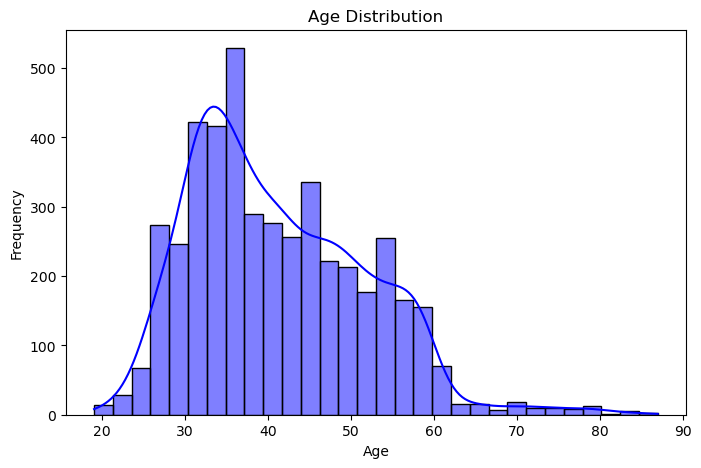

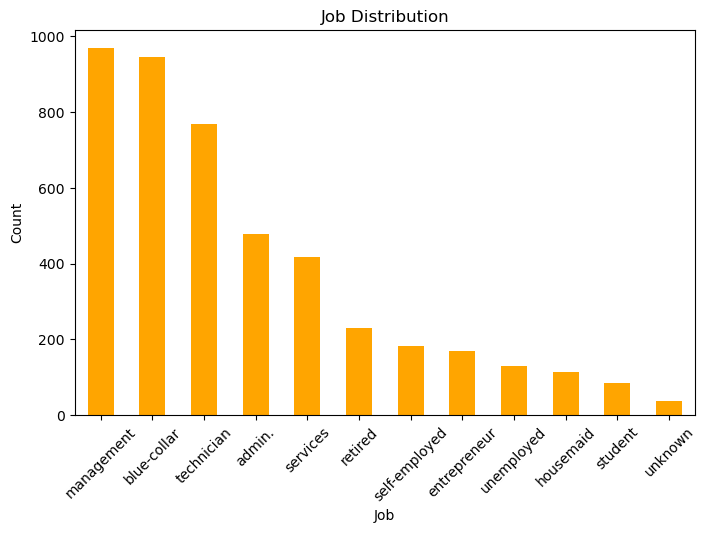

In [91]:
# Univariate analysis for age
plt.figure(figsize=(8, 5))
sns.histplot(df_final_cleaned['age'], bins=30, kde=True, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Univariate analysis for job
plt.figure(figsize=(8, 5))
df_final_cleaned['job'].value_counts().plot(kind='bar', color='orange')
plt.title('Job Distribution')
plt.xlabel('Job')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


The columns balance, campaign, and duration have maximum values significantly distant from their means, indicating potential outliers.

- pdays: The value -1 may require transformation or special handling.
- balance: Negative balances deserve further investigation.
- The ages are primarily concentrated between 30 and 50 years old.
- Certain professions, such as 'management' and 'blue-collar,' are more frequent.


Percentage distribution of 'y':
 y
no     88.476001
yes    11.523999
Name: proportion, dtype: float64


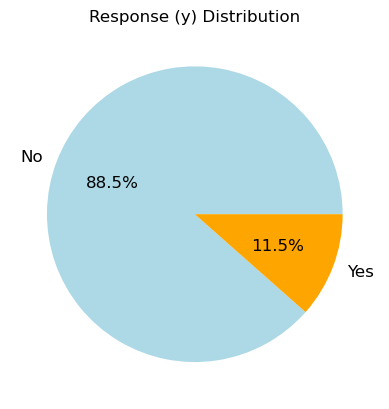

In [42]:
# Calculate the percentage distribution of 'y'
y_distribution = df_final_cleaned['y'].value_counts(normalize=True) * 100
print("Percentage distribution of 'y':\n", y_distribution)

# Optional pie chart visualization
y_distribution.plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'orange'], labels=['No', 'Yes'], fontsize=12)
plt.title('Response (y) Distribution')
plt.ylabel('')
plt.show()


- Approximately 86% of the responses are "no" (clients did not accept the offer).
- The remaining 14% represent "yes" (clients accepted the offer).

#### Bivariate & Multivariate Analysis
let's analyse each variable in relation to the others

##### Balance & Y

C:\Users\tmp_traore82643\AppData\Local\Temp\ipykernel_17932\2947380142.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='y', x='balance', data=df_final_cleaned, palette="Set3", orient='h')


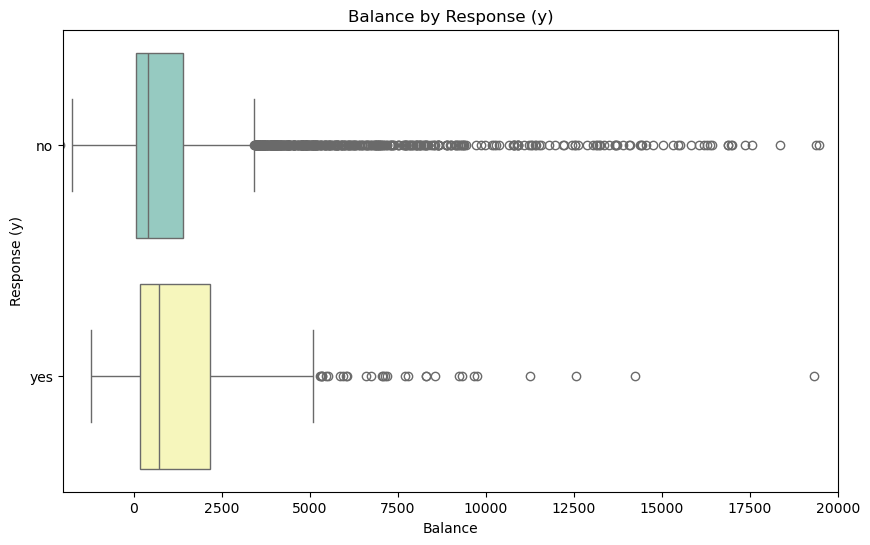

In [47]:
# Boxplot with zoomed scale
plt.figure(figsize=(10, 6))
sns.boxplot(y='y', x='balance', data=df_final_cleaned, palette="Set3", orient='h')
plt.title('Balance by Response (y)')
plt.xlabel('Balance')
plt.ylabel('Response (y)')
plt.xlim(-2000, 20000)  # Adjust scale for better visualization
plt.show()


Clients who responded "yes" also have a median bank balance close to zero, but the box is slightly higher than that of "no." Outliers are present, but their range is slightly smaller than that of the "no" class.








#### Duration & y 

C:\Users\tmp_traore82643\AppData\Local\Temp\ipykernel_17932\2629695965.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y='duration', data=df_final_cleaned, palette="coolwarm")


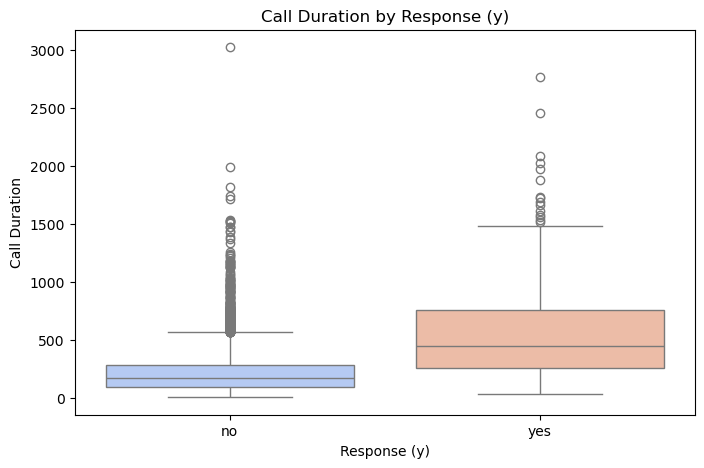

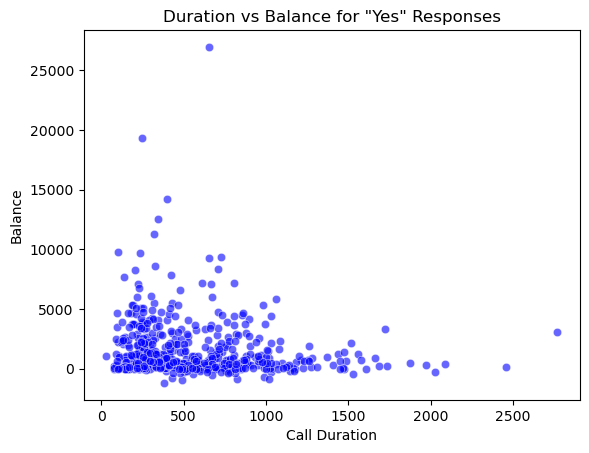

In [59]:
# Box plot to compare call duration for "yes" and "no"
plt.figure(figsize=(8, 5))
sns.boxplot(x='y', y='duration', data=df_final_cleaned, palette="coolwarm")
plt.title('Call Duration by Response (y)')
plt.xlabel('Response (y)')
plt.ylabel('Call Duration')
plt.show()

# Correlation between duration and balance for "yes"
yes_data = df_final_cleaned[df_final_cleaned['y'] == 'yes']
sns.scatterplot(x='duration', y='balance', data=yes_data, color='blue', alpha=0.6)
plt.title('Duration vs Balance for "Yes" Responses')
plt.xlabel('Call Duration')
plt.ylabel('Balance')
plt.show()


- The median call duration for "yes" responses is significantly higher than for "no" responses.
- Clients who responded "yes" had longer calls with a wider box, indicating more varied durations.
- Outliers exist in both classes, but those in "yes" show very long calls (> 2000 seconds).
- The majority of clients who responded "yes" have a bank balance close to zero, regardless of call duration.
- There is no strong correlation visible between balance and duration for this class.
- A few outliers show clients with high balances and long calls, but they are rare.

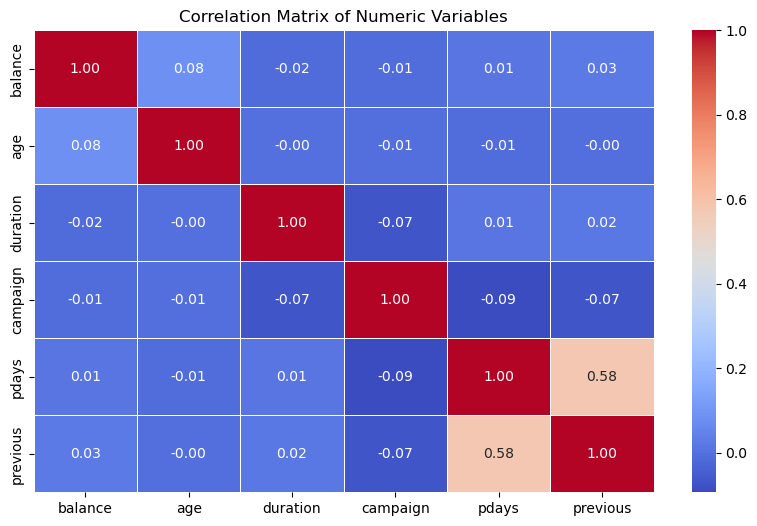

In [64]:
# Select only numeric columns
numeric_data = df_final_cleaned[['balance', 'age', 'duration', 'campaign', 'pdays', 'previous']]

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Variables')
plt.show()


- Most variables have very low correlation values with each other (close to 0), indicating weak linear relationships.

### Feature Processing & Engineering

In [92]:
# Check for missing values
missing_values = df_final_cleaned.isnull().sum()
print("Missing values per column:\n", missing_values)


Missing values per column:
 age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


#### Dataset spliting

In [102]:
# Split the dataset into features (X) and target (y)
X = df_final_cleaned.drop('y', axis=1)
y = df_final_cleaned['y']

In [103]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [106]:
# Convert 'day' to numeric if necessary
X_train['day'] = X_train['day'].astype(int)
X_test['day'] = X_test['day'].astype(int)


In [107]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3164 entries, 1244 to 3187
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        3164 non-null   int64   
 1   job        3164 non-null   category
 2   marital    3164 non-null   category
 3   education  3164 non-null   category
 4   default    3164 non-null   category
 5   balance    3164 non-null   int64   
 6   housing    3164 non-null   category
 7   loan       3164 non-null   category
 8   contact    3164 non-null   category
 9   day        3164 non-null   int32   
 10  month      3164 non-null   category
 11  duration   3164 non-null   int64   
 12  campaign   3164 non-null   int64   
 13  pdays      3164 non-null   int64   
 14  previous   3164 non-null   int64   
 15  poutcome   3164 non-null   category
dtypes: category(9), int32(1), int64(6)
memory usage: 215.0 KB


#### Feature Encoding 


In [108]:
# Example: One-Hot Encoding for categorical variables

categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns), index=X_train.index)
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns), index=X_test.index)


In [109]:
# Drop original categorical columns and add encoded columns
X_train = pd.concat([X_train.drop(categorical_columns, axis=1), X_train_encoded], axis=1)
X_test = pd.concat([X_test.drop(categorical_columns, axis=1), X_test_encoded], axis=1)

In [110]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
y_train_encoded = label_encoder.fit_transform(y_train)  # 'no' -> 0, 'yes' -> 1
y_test_encoded = label_encoder.transform(y_test)  # Ensure consistency for the test set

In [111]:
y_train_encoded

array([0, 0, 0, ..., 0, 0, 1])

#### Feature Scaling

In [112]:
numeric_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

#### New Feature Creation 
Create new features or interactions based on domain knowledge or insights from EDA.

In [99]:
# Example: Create new features
X_train['total_contacts'] = X_train['campaign'] + X_train['previous']
X_test['total_contacts'] = X_test['campaign'] + X_test['previous']

X_train['long_call'] = (X_train['duration'] > 300).astype(int)
X_test['long_call'] = (X_test['duration'] > 300).astype(int)


#### Machine Learning Modeling

Since our target variable (y) is imbalanced (88.48% no and 11.52% yes), consider applying 
- Oversampling: Use techniques like SMOTE to create synthetic samples for the minority class.


In [119]:
# Handle imbalanced classes with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_encoded)

##### Model Comparaison

In [130]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(class_weight='balanced', probability=True, random_state=42)
}
# Store results
results = []

# Evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_smote, y_train_smote)
    
    # Make predictions
    y_pred = model.predict(X_test)
    # ROC-AUC score
    y_proba = model.predict_proba(X_test)[:, 1]  # Predicted probabilities for "yes"
    roc_auc = roc_auc_score(y_test_encoded, y_proba)

    # Calculate metrics
    accuracy = accuracy_score(y_test_encoded, y_pred)
    precision = precision_score(y_test_encoded, y_pred, pos_label=1)
    recall = recall_score(y_test_encoded, y_pred, pos_label=1)
    f1 = f1_score(y_test_encoded, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test_encoded, y_proba)

    
    # Append results
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "roc_auc":roc_auc
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)


In [131]:
results_df

,Model,Accuracy,Precision,Recall,F1-Score,roc_auc
0,Logistic Regression,0.835667,0.390164,0.762821,0.516269,0.888939
1,Random Forest,0.887988,0.523256,0.288462,0.371901,0.894346
2,Gradient Boosting,0.885041,0.500000,0.551282,0.524390,0.900019
3,Support Vector Machine,0.868828,0.452991,0.679487,0.543590,0.888053


Gradient Boosting is a strong choice due to its high ROC-AUC (0.900019) and decent F1-Score (0.524390).
It provides a good balance between precision and recall.

 ##### Confusion Matrix

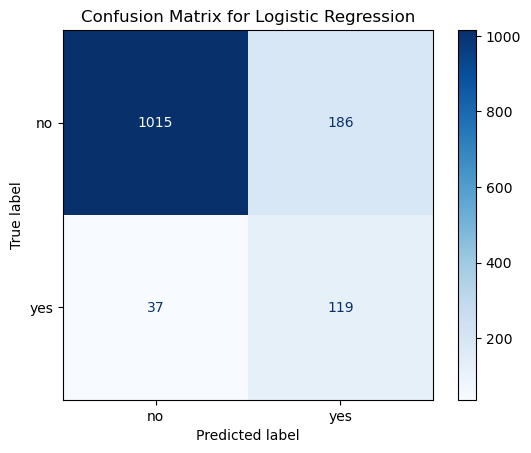

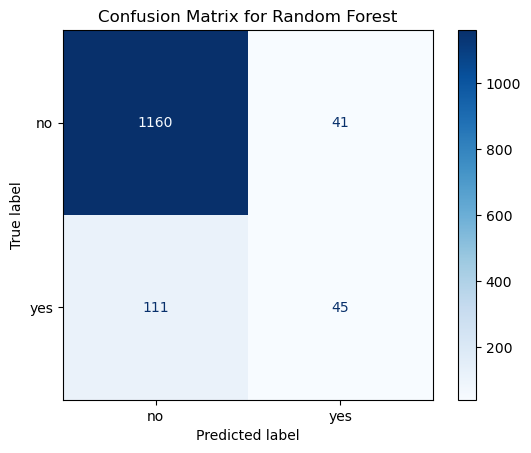

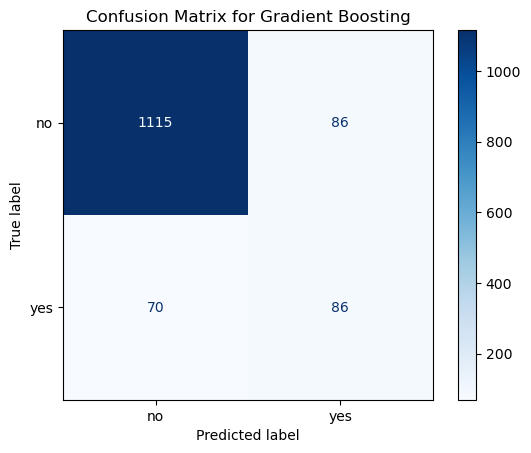

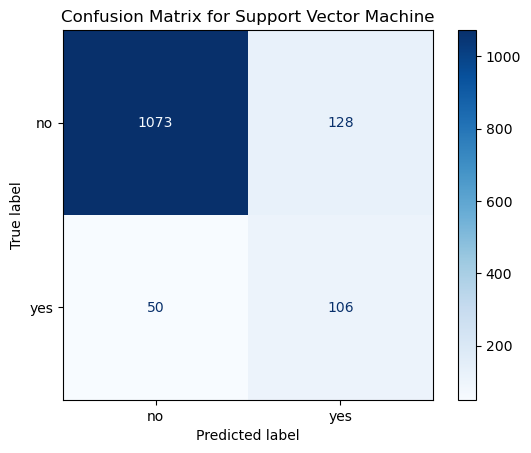

In [136]:
# Confusion matrix
# Iterate through the models to display confusion matrices
for model_name, model in models.items():
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test_encoded, y_pred)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no', 'yes'])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()



####  Hyperparameter Tuning with GridSearchCV


In [138]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],  # Shrinkage rate
    'max_depth': [3, 5, 7],  # Maximum depth of the tree
    'subsample': [0.8, 1.0],  # Fraction of samples used for fitting
    'min_samples_split': [2, 5, 10]  # Minimum samples required to split an internal node
}

# Initialize Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring='f1',  # Optimize for F1-Score
    cv=2,  # 5-fold cross-validation
    verbose=1,  # Show progress
    n_jobs=-1  # Use all available cores
)

# Fit the model to the training data
grid_search.fit(X_train_smote, y_train_smote)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

Fitting 2 folds for each of 162 candidates, totalling 324 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}


#####  Evaluate the Tuned Model
Once the best model is identified, evaluate its performance on the test set:

In [139]:
# Predict on the test set
y_pred = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(y_test_encoded, y_pred))

Confusion Matrix:
 [[1138   63]
 [  82   74]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      1201
           1       0.54      0.47      0.51       156

    accuracy                           0.89      1357
   macro avg       0.74      0.71      0.72      1357
weighted avg       0.89      0.89      0.89      1357



#### Export Key Components

In [147]:
import os

# Print the current working directory
print("Current Working Directory:", os.getcwd())


Current Working Directory: C:\Users\tmp_traore82643


In [ ]:
# Predict on the test set
y_pred = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(y_test_encoded, y_pred))

Confusion Matrix:
 [[1138   63]
 [  82   74]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      1201
           1       0.54      0.47      0.51       156

    accuracy                           0.89      1357
   macro avg       0.74      0.71      0.72      1357
weighted avg       0.89      0.89      0.89      1357



In [146]:
import joblib

# Save the trained Gradient Boosting model
# joblib.dump(best_model, 'gradient_boosting_model.pkl')
joblib.dump(encoder, "encoder.pkl")

# Load the model later for inference
# loaded_model = joblib.load('gradient_boosting_model.pkl')

# Example: Make predictions with the loaded model
# y_loaded_pred = loaded_model.predict(X_test)


['encoder.pkl']

In [145]:
!pip freeze > "C:/Users/tmp_traore82643/OneDrive - Orange Sonatel/Documents/requirements.txt"
